## Caso de Uso: Help Desk Agent con LangGraph

In [1]:
from __future__ import annotations

from typing import Literal, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, RetryPolicy
import os
from dotenv import load_dotenv

from langchain.chat_models import init_chat_model


### Definir estado

In [ ]:

Category = Literal["hardware", "software", "access", "network", "request", "other"]
Urgency = Literal["low", "medium", "high"]

class ITClassification(TypedDict):
    category: Category
    urgency: Urgency
    needs_more_info: bool
    missing_info: list[str]
    summary: str
    search_query: str


class HelpdeskState(TypedDict, total=False):
    # Raw email
    email_id: str
    sender_email: str
    subject: str
    body: str

    # Derived signals
    extracted: dict

    # LLM outputs / data outputs
    classification: ITClassification
    kb_results: list[str]

    # Generated content
    draft_reply: str

    # Validation + control
    validation_notes: list[str]
    draft_attempts: int


### Fuentes de datos (keyword-based simplificada)

In [ ]:

KB_DOCS = [
    "Outlook/M365: If you can't access corporate email, check MFA, reset token, and try signing in via webmail. If VPN is required, connect first.",
    "Laptop won't turn on: Check charger/USB-C cable, try long-press power 10s, disconnect peripherals, and verify battery/charging indicator.",
    "New software install: Provide app name, OS version, and device type. Use Company Portal (Intune) when available; otherwise request admin install.",
    "Password reset (internal): Use Self-Service Password Reset portal, verify MFA, then set a new password that meets policy requirements.",
    "VPN issues: Confirm Wi-Fi works, restart VPN client, verify credentials/MFA, and check status page for incidents.",
]

In [11]:
def simple_kb_search(query: str, k: int = 3) -> list[str]:
    """Very simple keyword-based search to keep the demo small."""
    q = query.lower()
    scored = []
    for doc in KB_DOCS:
        score = sum(1 for w in q.split() if w and w in doc.lower())
        scored.append((score, doc))
    scored.sort(key=lambda x: x[0], reverse=True)
    return [d for s, d in scored[:k] if s > 0] or ["No relevant internal docs found for this query."]


### Modelo

In [12]:
load_dotenv()

model = init_chat_model(
    model="claude-sonnet-4-5-20250929",
    model_provider="anthropic",
    api_key=os.getenv("ANTHROPIC_API_KEY"),
    temperature=0
)

### Construir nodos

In [ ]:
def read_email(state: HelpdeskState) -> dict:
    """In production, fetch/parse from mailbox. Here we assume state already contains email fields."""
    return {
        "draft_attempts": state.get("draft_attempts", 0),
        "validation_notes": state.get("validation_notes", []),
    }

def extract_details(state: HelpdeskState) -> dict:
    text = f"{state.get('subject','')}\n{state.get('body','')}".lower()
    extracted = {
        "mentions_laptop": "laptop" in text or "portátil" in text or "macbook" in text,
        "mentions_email": "email" in text or "outlook" in text or "correo" in text,
        "mentions_vpn": "vpn" in text,
        "mentions_install": "install" in text or "instal" in text,
        "mentions_access": "can't access" in text or "no puedo acceder" in text or "login" in text,
    }
    return {"extracted": extracted}

def classify_request(state: HelpdeskState) -> Command[
    Literal["kb_search", "draft_reply"]
]:
    """LLM classifies and decides whether we can proceed or we must ask for more info."""
    structured = model.with_structured_output(ITClassification)

    prompt = f"""
        You are an IT help desk assistant for an office.
        Classify the employee email into:
        - category: hardware / software / access / network / request / other
        - urgency: low / medium / high
        - needs_more_info: true if you cannot provide actionable steps without key details
        - missing_info: list of required missing items (e.g., device model, OS, exact error, screenshot)
        - summary: 1 sentence
        - search_query: short query to search internal KB

        Email subject: {state.get("subject","")}
        From: {state.get("sender_email","")}
        Email body:
        {state.get("body","")}
        """

    classification = structured.invoke(prompt)

    # If we need more info, we skip KB search and draft a questions-email
    goto = "draft_reply" if classification["needs_more_info"] else "kb_search"

    return Command(
        update={"classification": classification},
        goto=goto,
    )

def kb_search(state: HelpdeskState) -> Command[Literal["draft_reply"]]:
    cls = state["classification"]
    results = simple_kb_search(cls["search_query"], k=3)
    return Command(update={"kb_results": results}, goto="draft_reply")

def draft_reply(state: HelpdeskState) -> Command[Literal["validate_reply"]]:
    cls = state["classification"]
    kb = state.get("kb_results", [])

    # Build context on-demand (keep state raw)
    kb_block = "\n".join([f"- {x}" for x in kb]) if kb else "- (no docs)"

    if cls["needs_more_info"]:
        instruction = (
            "Draft a short email asking ONLY for the missing information, "
            "and explain why it is needed. Be concise."
        )
        missing = "\n".join([f"- {x}" for x in cls["missing_info"]]) or "- (none listed)"
        context = f"Missing info:\n{missing}"
    else:
        instruction = (
            "Draft a helpful, step-by-step IT help desk email. "
            "Use the KB snippets as guidance. Keep it practical."
        )
        context = f"Relevant internal KB snippets:\n{kb_block}"

    safety = (
        "Never ask for passwords or MFA codes. "
        "If credentials are relevant, ask the user to use official reset flows."
    )

    prompt = f"""
        {instruction}
        {safety}

        Employee email:
        Subject: {state.get("subject","")}
        Body: {state.get("body","")}

        Classification:
        - category: {cls["category"]}
        - urgency: {cls["urgency"]}
        - summary: {cls["summary"]}

        {context}

        Output: an email reply (no extra commentary).
        """
    reply = model.invoke(prompt)

    return Command(
        update={"draft_reply": reply.content, "draft_attempts": state.get("draft_attempts", 0) + 1},
        goto="validate_reply",
    )

def validate_reply(state: HelpdeskState) -> Command[Literal["send_reply", "draft_reply"]]:
    """Simple policy checks; if it fails, we redraft once."""
    text = (state.get("draft_reply") or "").lower()
    notes = []

    banned = ["password", "contraseña", "mfa code", "código mfa", "otp", "2fa code"]
    if any(b in text for b in banned):
        notes.append("Draft asked for a password/MFA code. Must be removed.")

    # If fails and we still have attempts left, loop back to draft
    attempts = state.get("draft_attempts", 0)
    if notes and attempts < 2:
        # Add a note to state so the next draft can correct itself
        existing = state.get("validation_notes", [])
        return Command(update={"validation_notes": existing + notes}, goto="draft_reply")

    return Command(update={"validation_notes": state.get("validation_notes", []) + notes}, goto="send_reply")

def send_reply(state: HelpdeskState) -> Command[Literal["log_result"]]:
    """Integrate with email provider in production."""
    print("\n=== SENDING EMAIL ===")
    print(f"To: {state.get('sender_email')}")
    print(state.get("draft_reply", ""))
    print("=====================\n")
    return Command(update={}, goto="log_result")

def log_result(state: HelpdeskState) -> dict:
    """Store analytics / auditing info in production."""
    cls = state.get("classification", {})
    print(f"[LOG] category={cls.get('category')} urgency={cls.get('urgency')} email_id={state.get('email_id')}")
    return {}


### Enlazar - Workflow

In [ ]:
workflow = StateGraph(HelpdeskState)

workflow.add_node("read_email", read_email)
workflow.add_node("extract_details", extract_details)
workflow.add_node("classify_request", classify_request)

workflow.add_node(
    "kb_search",
    kb_search,
    retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0),
)

workflow.add_node("draft_reply", draft_reply)
workflow.add_node("validate_reply", validate_reply)
workflow.add_node("send_reply", send_reply)
workflow.add_node("log_result", log_result)

# Essential edges (routing happens inside nodes via Command.goto)
workflow.add_edge(START, "read_email")
workflow.add_edge("read_email", "extract_details")
workflow.add_edge("extract_details", "classify_request")
workflow.add_edge("log_result", END)

app = workflow.compile()



### Probar el agente

In [16]:
initial_state: HelpdeskState = {
    "email_id": "it_001",
    "sender_email": "ddiaz@bisbedev.com",
    "subject": "Problemas para acceder al correo - móvil",
    "body": "Hola, he cambiado de móvil a un iPhone 17 hoy y ahora no puedo acceder a Outlook desde la app. Sigue fallando al iniciar sesión. ¿Me podéis ayudar?",
}

# Run
final_state = app.invoke(initial_state)


=== SENDING EMAIL ===
To: ddiaz@bisbedev.com
**Subject:** RE: Problemas para acceder al correo - móvil

Hola,

Para poder ayudarte con el problema de acceso a Outlook en tu nuevo iPhone, necesito algunos datos adicionales:

- ¿Qué mensaje de error exacto aparece cuando intentas iniciar sesión?
- ¿Qué versión de iOS tiene tu iPhone 17?
- ¿Has probado a desinstalar y reinstalar la app de Outlook?
- ¿Tienes configurada la autenticación de doble factor (MFA) en tu cuenta?

Esta información nos permitirá identificar si el problema es de configuración de la app, compatibilidad del sistema o relacionado con la autenticación.

Saludos,
IT Support

[LOG] category=access urgency=medium email_id=it_001


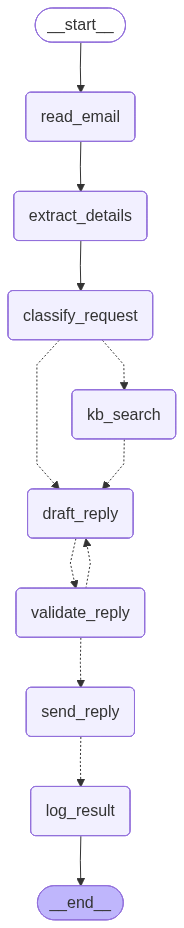

In [15]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### Observar el grafo del agente con mermaid

In [ ]:
# Mermaid (para pegarlo en Mermaid Live / docs)
print(app.get_graph(xray=True).draw_mermaid())

<img src="images/result_graph.png" alt="Grafo del agente Help Desk" width="300">